# Support Vector Machine (SVM) for Disease Prediction

## 1. Import Libraries

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance
import shap
from itertools import cycle

In [88]:
import warnings
warnings.filterwarnings('ignore')

## 2. Load data

In [89]:
# Load the dataset
file_path = '../../data/raw/dataset.csv'
dataset = pd.read_csv(file_path)

# Define features (X) and target variable (y)
X = dataset.drop(columns=['Disease'])
y = dataset['Disease']

#Identify Unique Symptoms Across All Columns ---
unique_symptoms = set()
for col in X.columns:
    if col.startswith('Symptom'):
        unique_symptoms.update(X[col].dropna().unique())

# Print the number of unique symptoms to verify we have the expected number
print(f"Total unique symptoms: {len(unique_symptoms)}")
print(f"Unique symptoms (first 20): {list(unique_symptoms)[:20]}")


Total unique symptoms: 131
Unique symptoms (first 20): [' movement_stiffness', ' acute_liver_failure', ' fatigue', ' nausea', ' small_dents_in_nails', ' continuous_sneezing', ' inflammatory_nails', ' malaise', ' muscle_weakness', ' abnormal_menstruation', ' loss_of_balance', ' swollen_blood_vessels', ' family_history', ' swelled_lymph_nodes', ' weight_loss', ' back_pain', ' cold_hands_and_feets', ' burning_micturition', ' red_sore_around_nose', ' pain_behind_the_eyes']


## Pre-processing : Encoding and Scaling

In [90]:
#Create Multi-Hot Encoding for Each Row ---
# Initialize the binary encoding for each symptom (multi-hot)
binary_columns = pd.DataFrame()

for symptom in unique_symptoms:
    # Create a binary vector for each symptom, indicating presence (1) or absence (0)
    binary_columns[symptom] = X.apply(lambda row: 1 if symptom in row.values else 0, axis=1)

# Encode the Target Variable with Label Encoding 
label_encoder_y = LabelEncoder()
y_encoded = label_encoder_y.fit_transform(y)

#Feature Scaling ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(binary_columns)

In [91]:
binary_columns_sample = binary_columns.head(10)  # Show first 10 rows
print(binary_columns_sample.to_markdown())

|    |    movement_stiffness |    acute_liver_failure |    fatigue |    nausea |    small_dents_in_nails |    continuous_sneezing |    inflammatory_nails |    malaise |    muscle_weakness |    abnormal_menstruation |    loss_of_balance |    swollen_blood_vessels |    family_history |    swelled_lymph_nodes |    weight_loss |    back_pain |    cold_hands_and_feets |    burning_micturition |    red_sore_around_nose |    pain_behind_the_eyes |    fluid_overload |    receiving_unsterile_injections |    chest_pain |    mild_fever |    dischromic _patches |    swollen_extremeties |    internal_itching |    passage_of_gases |    weakness_of_one_body_side |    ulcers_on_tongue |    painful_walking |    puffy_face_and_eyes |    runny_nose |    fast_heart_rate |    swollen_legs |    mood_swings |    anxiety |    yellow_crust_ooze |    knee_pain |    muscle_wasting |    yellow_urine |    toxic_look_(typhos) |    depression |    sunken_eyes |    enlarged_thyroid |    throat_irritation |    drying_

In [92]:
# Display the label mapping as a Markdown table
print(label_mapping_sample.to_markdown())

|    | Original Label      |   Encoded Label |
|---:|:--------------------|----------------:|
|  0 | Fungal infection    |              15 |
|  1 | Fungal infection    |              15 |
|  2 | Fungal infection    |              15 |
|  3 | Fungal infection    |              15 |
|  4 | Fungal infection    |              15 |
|  5 | Fungal infection    |              15 |
|  6 | Fungal infection    |              15 |
|  7 | Fungal infection    |              15 |
|  8 | Fungal infection    |              15 |
|  9 | Fungal infection    |              15 |
| 10 | Allergy             |               4 |
| 11 | Allergy             |               4 |
| 12 | Allergy             |               4 |
| 13 | Allergy             |               4 |
| 14 | Allergy             |               4 |
| 15 | Allergy             |               4 |
| 16 | Allergy             |               4 |
| 17 | Allergy             |               4 |
| 18 | Allergy             |               4 |
| 19 | Allerg

In [93]:
X_scaled

array([[-0.15401412, -0.15401412, -0.80410593, ..., -0.15401412,
        -0.15401412, -0.31728716],
       [-0.15401412, -0.15401412, -0.80410593, ..., -0.15401412,
        -0.15401412, -0.31728716],
       [-0.15401412, -0.15401412, -0.80410593, ..., -0.15401412,
        -0.15401412, -0.31728716],
       ...,
       [-0.15401412, -0.15401412, -0.80410593, ..., -0.15401412,
        -0.15401412, -0.31728716],
       [-0.15401412, -0.15401412, -0.80410593, ..., -0.15401412,
        -0.15401412, -0.31728716],
       [-0.15401412, -0.15401412, -0.80410593, ..., -0.15401412,
        -0.15401412, -0.31728716]])

## 3. Feature Selection using Random Forest Before SVM training

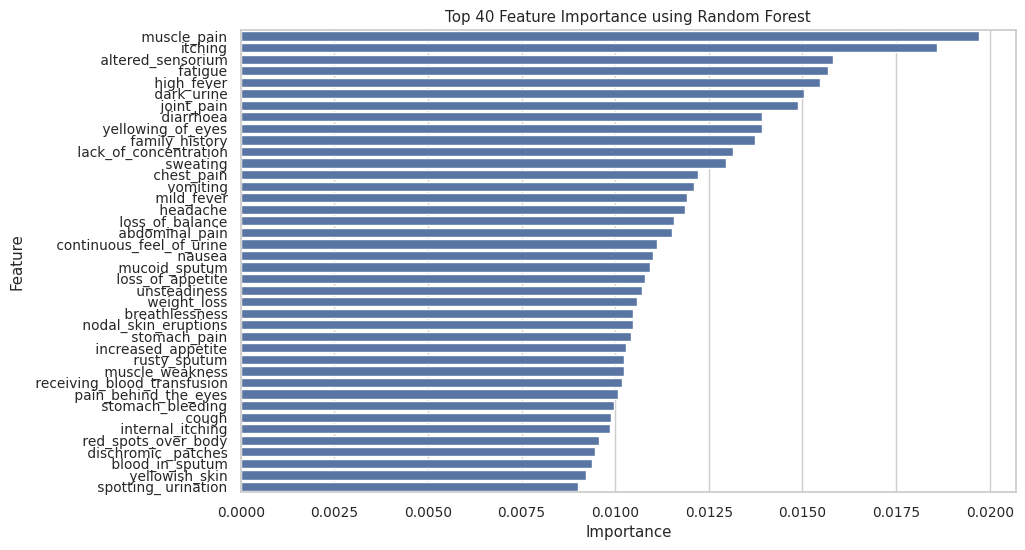

In [94]:
# Feature selection using Random Forest to assess feature importance 
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)  
rf_model.fit(X_scaled, y_encoded)

# Feature importance
feature_importances = rf_model.feature_importances_
feature_names = binary_columns.columns

# Create a DataFrame for better visualization
importance_rf_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_rf_df = importance_rf_df.sort_values(by='Importance', ascending=False)

# Visualize feature importances
# Adjust the plot to show only the top 20 most important features for better readability
top_n = 40
importance_rf_df_top = importance_rf_df.head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_rf_df_top)
plt.title(f"Top {top_n} Feature Importance using Random Forest")
plt.show()

### Interpretation of Random Forest Feature Importance
The bar chart above shows the importance score calculated by the Random Forest model for each symptom (feature). Features with higher scores are considered more important by the model for making predictions. We used the mean importance score as a threshold to select a subset of features for training the SVM model. This helps in reducing dimensionality and potentially improving model performance by focusing on the most relevant symptoms.

In [95]:
# Select features with importance greater than a threshold (mean importance) 
threshold = np.mean(feature_importances)  # Using mean importance as threshold

# Apply SelectFromModel to select features based on threshold
selector = SelectFromModel(rf_model, threshold=threshold, prefit=True)

# Transform the entire feature set to retain only important features
X_scaled_selected = selector.transform(X_scaled)

# Get the selected feature names based on the threshold
selected_features = feature_names[selector.get_support()]

print(f"Selected {len(selected_features)} features based on threshold {threshold:.4f}:")
print(selected_features.tolist())

# --- Step 7: Split data into training and test sets ---
X_train_selected, X_test, y_train, y_test = train_test_split(X_scaled_selected, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Print the shape of training and test sets
print(f"\nShape of X_train_selected: {X_train_selected.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Number of classes: {len(label_encoder_y.classes_)}")


Selected 59 features based on threshold 0.0076:
[' fatigue', ' nausea', ' malaise', ' muscle_weakness', ' abnormal_menstruation', ' loss_of_balance', ' family_history', ' swelled_lymph_nodes', ' weight_loss', ' back_pain', ' pain_behind_the_eyes', ' chest_pain', ' mild_fever', ' dischromic _patches', ' internal_itching', ' passage_of_gases', ' fast_heart_rate', ' yellow_crust_ooze', ' toxic_look_(typhos)', ' sunken_eyes', ' abdominal_pain', ' mucoid_sputum', ' joint_pain', ' cough', ' spotting_ urination', ' sweating', ' hip_joint_pain', ' yellowing_of_eyes', ' coma', ' unsteadiness', ' stomach_pain', ' diarrhoea', ' shivering', ' dark_urine', ' receiving_blood_transfusion', ' headache', ' bladder_discomfort', 'itching', ' yellowish_skin', ' blood_in_sputum', ' loss_of_appetite', ' high_fever', ' nodal_skin_eruptions', ' lack_of_concentration', ' neck_pain', ' palpitations', ' muscle_pain', ' increased_appetite', ' skin_peeling', ' continuous_feel_of_urine', ' red_spots_over_body', ' v

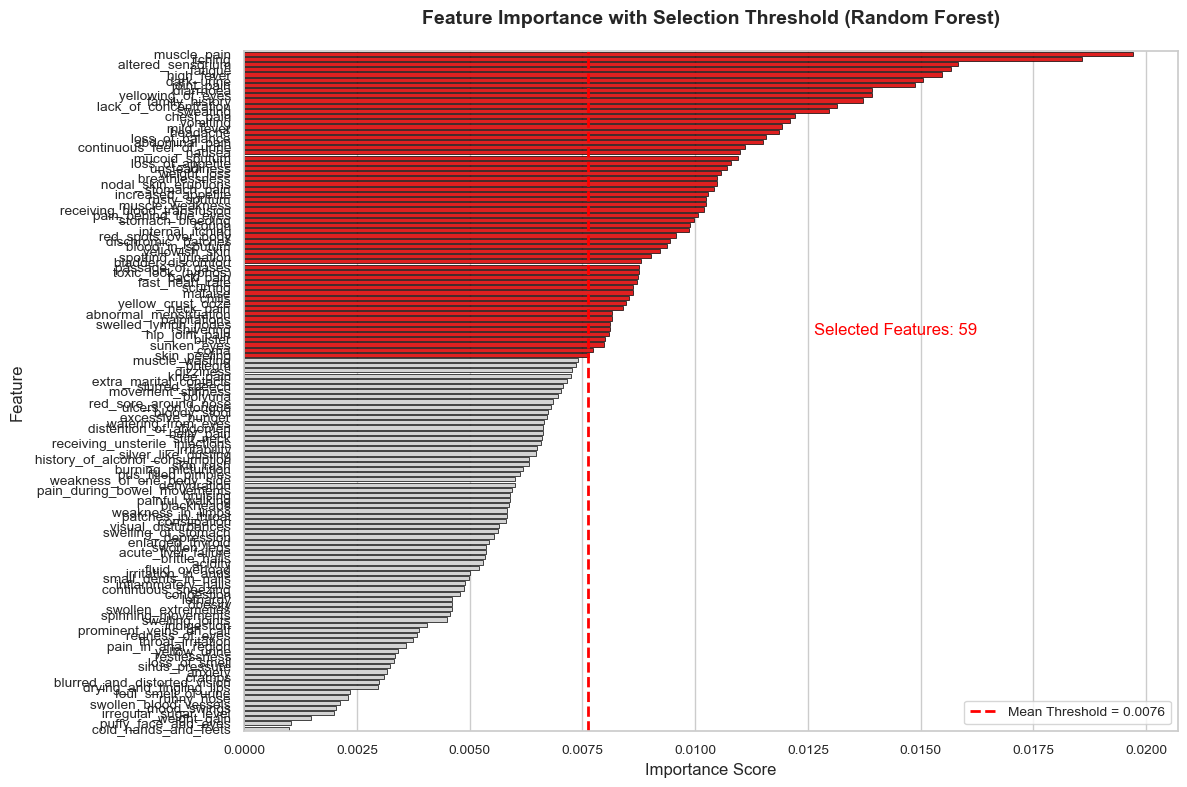

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Plot all features' importance (sorted)
sns.barplot(
    x="Importance",
    y="Feature",
    data=importance_rf_df,
    palette=["red" if x >= threshold else "lightgray" for x in importance_rf_df["Importance"]],
    edgecolor="black",
    linewidth=0.5
)

# Add mean threshold line
plt.axvline(
    x=threshold,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean Threshold = {threshold:.4f}"
)

# Annotate selected features
plt.text(
    threshold + 0.005,
    len(selected_features) - 5,
    f"Selected Features: {len(selected_features)}",
    color="red",
    fontsize=12,
    ha="left"
)

# Customize plot
plt.title("Feature Importance with Selection Threshold (Random Forest)", fontsize=14, pad=20, fontweight="bold")
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.legend(loc="lower right")
plt.tight_layout()

# Save for report
plt.savefig("feature_selection_threshold.png", dpi=300, bbox_inches="tight")
plt.show()

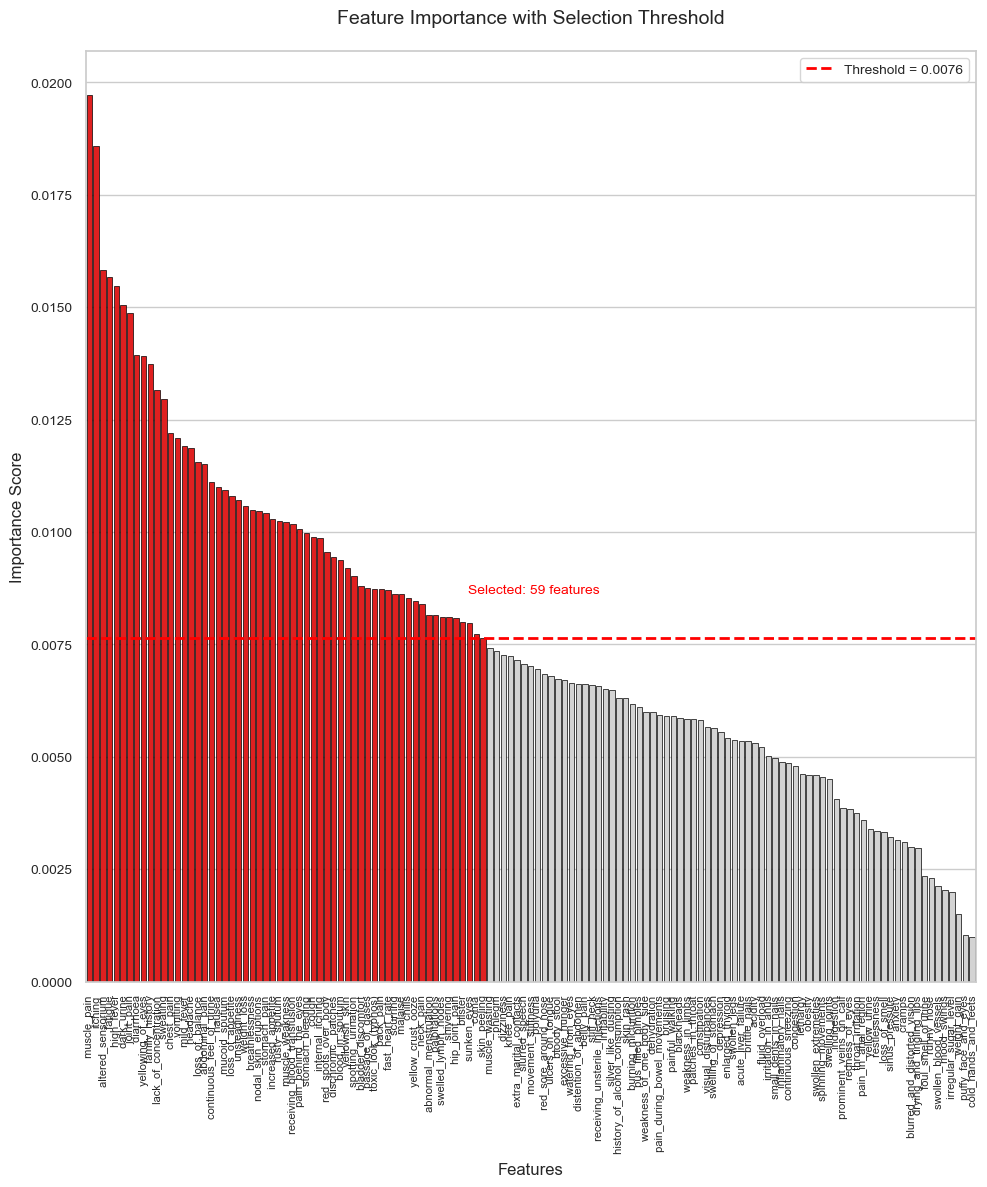

In [97]:
plt.figure(figsize=(10, 12))  # Wider and taller

# Plot ALL features (not just top_n) to show the full distribution
ax = sns.barplot(
    y="Importance",
    x="Feature",
    data=importance_rf_df.sort_values("Importance", ascending=False),  # Use full sorted DataFrame
    palette=["red" if x >= threshold else "lightgray" for x in importance_rf_df["Importance"]],
    edgecolor="black",
    linewidth=0.5
)

# Rotate x-axis labels for readability
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    ha='center',
    fontsize=8  # Smaller font to fit more labels
)

# Add threshold line and annotation
plt.axhline(y=threshold, color="red", linestyle="--", linewidth=2, label=f"Threshold = {threshold:.4f}")
plt.text(
    x=0.5 * len(importance_rf_df),  # Middle of x-axis
    y=threshold + 0.001,  # Slightly above threshold line
    s=f"Selected: {len(selected_features)} features",
    color="red",
    ha="center",
    fontsize=10
)

# Customize layout
plt.title("Feature Importance with Selection Threshold", fontsize=14, pad=20)
plt.ylabel("Importance Score", fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.legend(loc="upper right")
plt.tight_layout()

# Save
plt.savefig("feature_importance_full.png", dpi=300, bbox_inches="tight")
plt.show()

In [98]:
import pandas as pd

# Create a DataFrame of selected features and their importance
selected_features_df = importance_rf_df[importance_rf_df["Importance"] >= threshold].sort_values("Importance", ascending=False)

print(f"\nSelected Features (Threshold = {threshold:.4f}):")
selected_features_df = selected_features_df.style.background_gradient(cmap="Reds", subset=["Importance"])
display(selected_features_df)


Selected Features (Threshold = 0.0076):


,Feature,Importance
95,muscle_pain,0.019709
83,itching,0.018579
129,altered_sensorium,0.015821
2,fatigue,0.015676
87,high_fever,0.015471
75,dark_urine,0.015048
56,joint_pain,0.014867
72,diarrhoea,0.013930
64,yellowing_of_eyes,0.013916
12,family_history,0.013728


In [99]:
# X_train_selected, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


## 4. Train SVM Model (Initial)

In [100]:
# Train the SVM model using selected features
svm_model = SVC(probability=True, random_state=42, C=1.0, kernel='rbf')
svm_model.fit(X_train_selected, y_train)

# Predict on the test set
y_pred_svm = svm_model.predict(X_test)
y_proba_svm = svm_model.predict_proba(X_test)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm, target_names=label_encoder_y.classes_)

# Print accuracy and classification report
print(f"SVM Model Accuracy (Initial): {accuracy_svm:.4f}")
print("\nClassification Report (Initial):")
print(report_svm)

SVM Model Accuracy (Initial): 0.9909

Classification Report (Initial):
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        24
                                   AIDS       1.00      0.92      0.96        24
                                   Acne       1.00      0.92      0.96        24
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      0.92      0.96        24
                       Bronchial Asthma       1.00      1.00      1.00        24
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox       1.00      1.00      1.00        24
                    Chronic cholestasis       1.00      1.00      1.00        24
                            Common Co

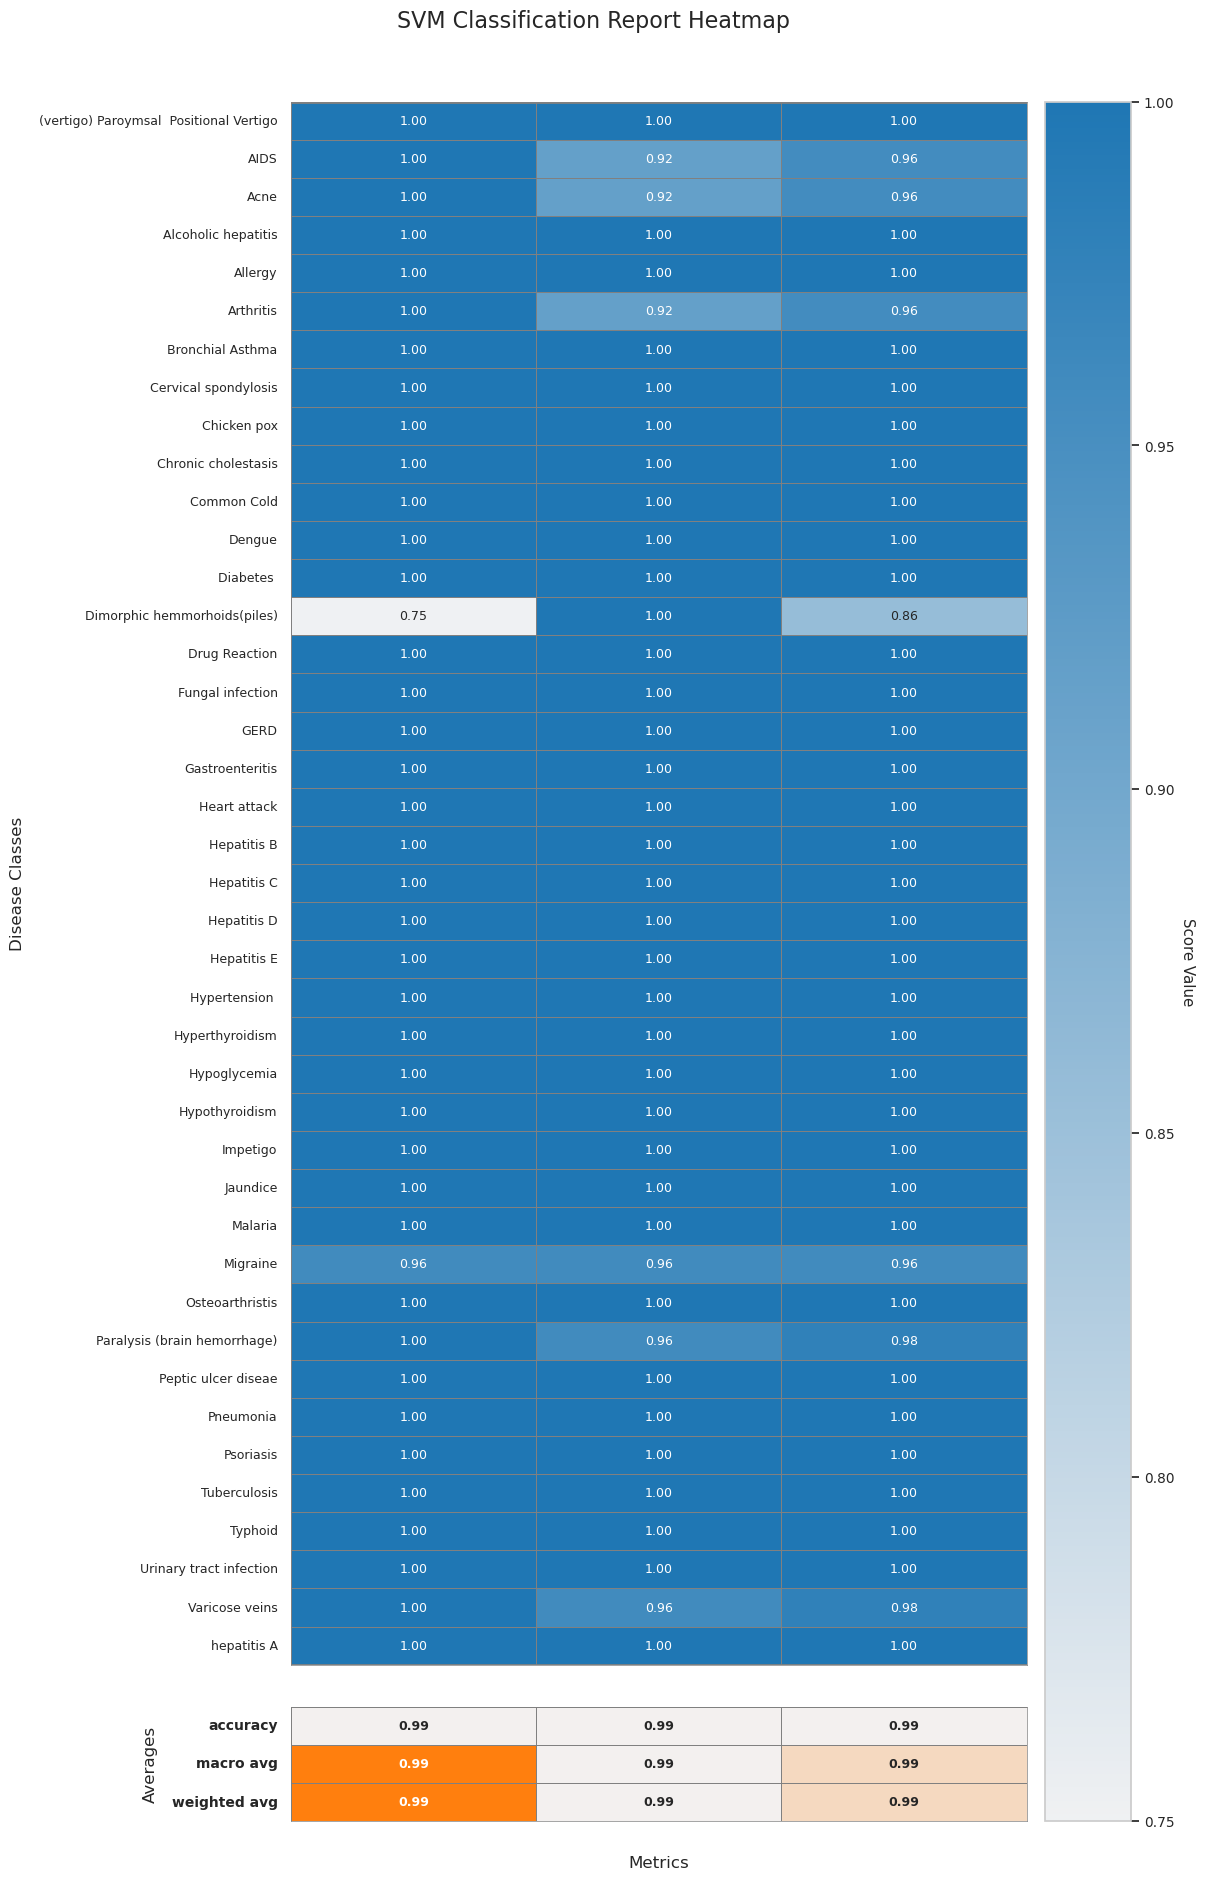

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd

# Generate report as DataFrame
report_dict = classification_report(y_test, y_pred_svm, target_names=label_encoder_y.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Separate the class metrics from the averages
class_metrics = report_df.iloc[:-3, :3]  # Precision, Recall, F1 for classes
avg_metrics = report_df.iloc[-3:, :3]    # Precision, Recall, F1 averages

# Adjust plot size dynamically based on number of classes
num_classes = len(class_metrics)
height_per_class = 0.4  
fig_height = max(6, num_classes * height_per_class)

# Set font and style
sns.set(style="whitegrid", font_scale=0.9)
plt.rcParams['font.family'] = 'DejaVu Sans' 

# Create figure with two subplots - one for classes, one for averages
fig, (ax1, ax2) = plt.subplots(
    nrows=2, 
    figsize=(12, fig_height + 2),  
    gridspec_kw={'height_ratios': [num_classes, 3]},
    sharex=True
)

# Main colormap for classes
cmap_main = sns.light_palette("#1f77b4", as_cmap=True)
cmap_avg = sns.light_palette("#ff7f0e", as_cmap=True)  

# Draw heatmap for classes
sns.heatmap(
    class_metrics,
    annot=True,
    cmap=cmap_main,
    fmt='.2f',
    linewidths=0.4,
    linecolor='gray',
    cbar=False,
    square=False,
    ax=ax1,
    annot_kws={'fontsize': 9}
)

# Draw heatmap for averages
sns.heatmap(
    avg_metrics,
    annot=True,
    cmap=cmap_avg,
    fmt='.2f',
    linewidths=0.4,
    linecolor='gray',
    cbar=False,
    square=False,
    ax=ax2,
    annot_kws={'fontsize': 9, 'fontweight': 'bold'}
)

# Titles & labels
fig.suptitle('SVM Classification Report Heatmap', fontsize=16, y=1.02)
ax1.set_ylabel('Disease Classes', fontsize=12, labelpad=10)
ax2.set_ylabel('Averages', fontsize=12, labelpad=10)
ax2.set_xlabel('Metrics', fontsize=12, labelpad=15)

# Ticks styling
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, fontsize=10)
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=9)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, fontsize=10)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, fontsize=10, fontweight='bold')

# Add borders
for ax in [ax1, ax2]:
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)

# Add a divider between the two heatmaps
ax1.axhline(y=0, color='gray', linewidth=2)
ax1.axhline(y=len(class_metrics), color='gray', linewidth=2)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.05) 

# Add a colorbar for the main heatmap
cbar = fig.colorbar(ax1.collections[0], ax=[ax1, ax2], location='right', pad=0.02)
cbar.ax.set_ylabel('Score Value', rotation=270, labelpad=15)

plt.show()

## 5. Evaluate Initial SVM Model

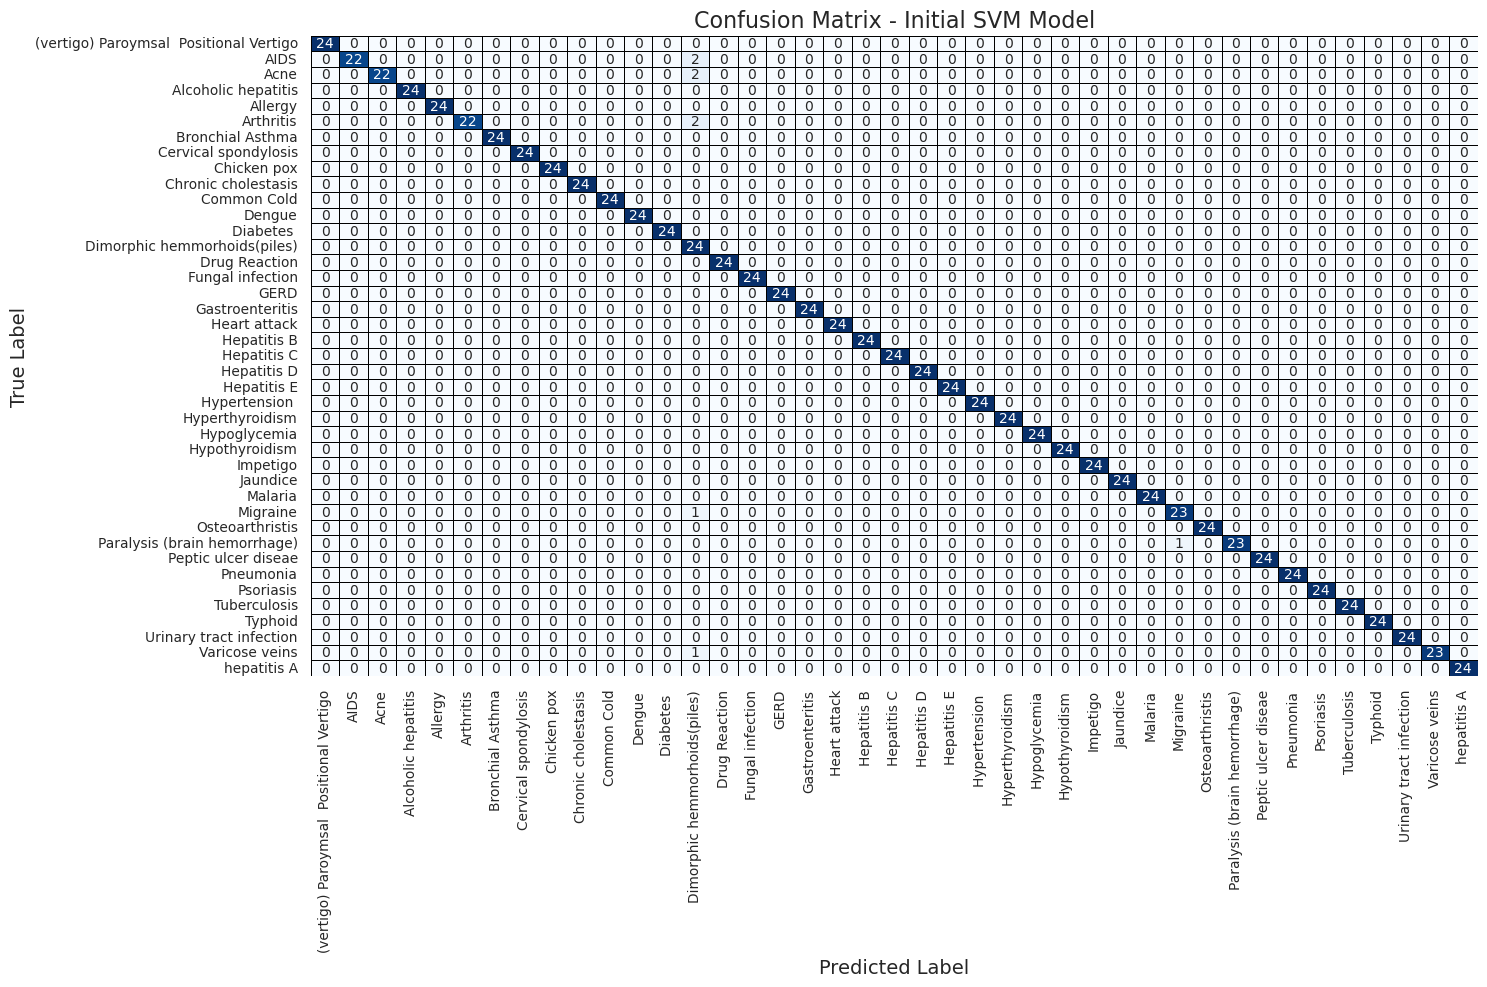

In [102]:
# --- Confusion Matrix --- 
conf_matrix = confusion_matrix(y_test, y_pred_svm)

# Create a larger figure and adjust font sizes for better readability
plt.figure(figsize=(15, 10))

# Use a heatmap with a color map
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder_y.classes_, yticklabels=label_encoder_y.classes_,
            annot_kws={"size": 10}, linewidths=0.5, linecolor='black')

# Adding titles and axis labels
plt.title("Confusion Matrix - Initial SVM Model", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

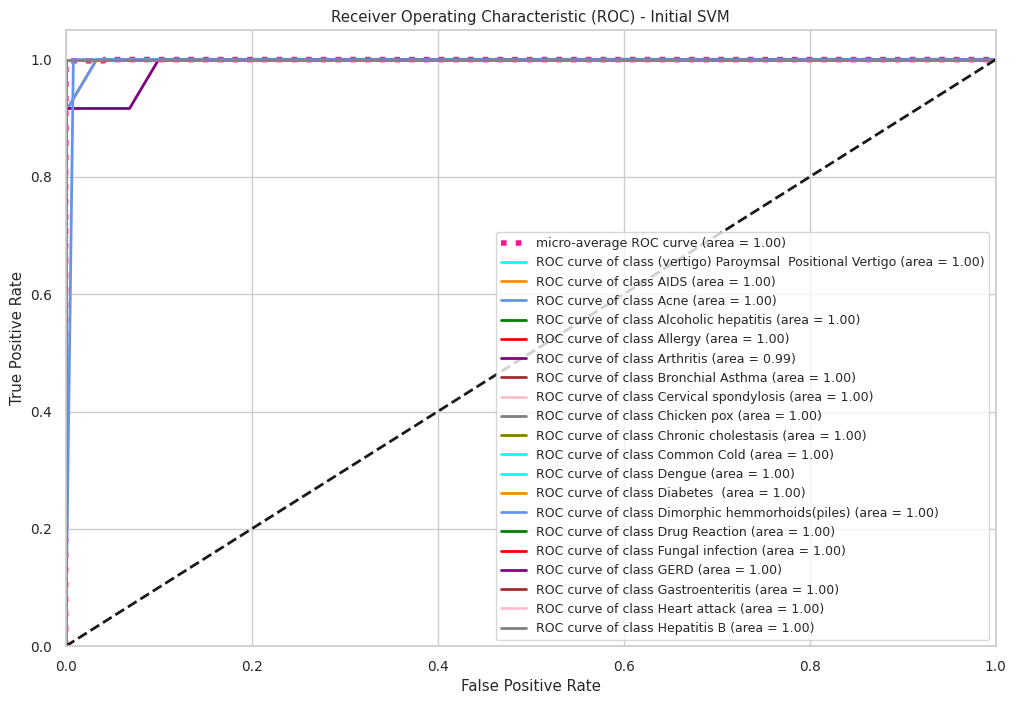

In [103]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Ensure n_classes is defined as the number of unique classes in y_test
n_classes = len(np.unique(y_test))

# Binarize the output labels for multi-class ROC analysis
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba_svm[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_proba_svm.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
num_classes_to_plot = min(n_classes, 20) # Plot only the first 20 classes if there are too many
for i, color in zip(range(num_classes_to_plot), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_encoder_y.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Initial SVM')
plt.legend(loc="lower right", fontsize='small')
plt.show()


### Interpretation of Confusion Matrix and ROC/AUC
**Confusion Matrix:** This matrix shows the performance of the classification model. Each row represents the instances in an actual class while each column represents the instances in a predicted class. It helps visualize where the model is confusing different diseases.

**ROC/AUC Curve:** The Receiver Operating Characteristic (ROC) curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. The Area Under the Curve (AUC) provides an aggregate measure of performance across all possible classification thresholds. An AUC closer to 1 indicates a better model. The micro-average aggregates the contributions of all classes to compute the average metric.

## 6. Hyperparameter Tuning with GridSearchCV

In [104]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(svm_model, X_train_selected, y_train, cv=5)  
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Average cross-validation accuracy: {np.mean(cv_scores)}")


Cross-validation accuracy scores: [0.99619289 0.99110546 0.98983482 0.99110546 0.98475222]
Average cross-validation accuracy: 0.9905981720728333


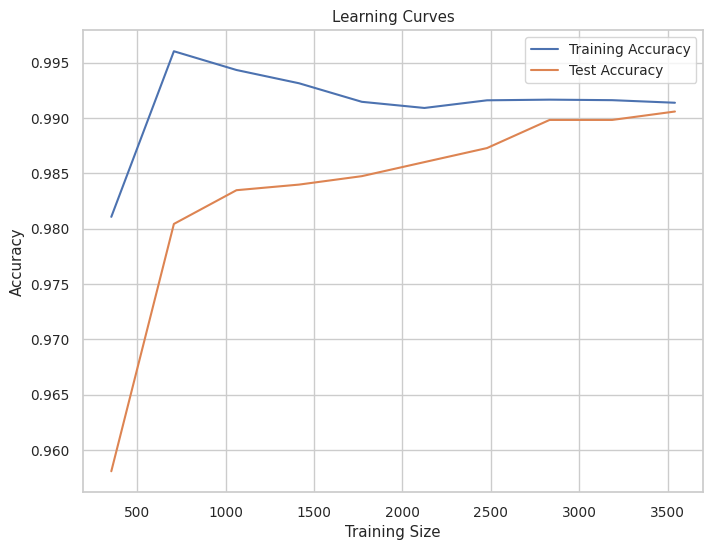

In [105]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    svm_model, X_train_selected, y_train, cv=10, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Training Accuracy")
plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Test Accuracy")
plt.title("Learning Curves")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [107]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 50], # Added more C values
    'kernel': ['rbf', 'linear'], # Focusing on common kernels
    'gamma': ['scale', 'auto', 0.1, 1] # Added numerical gamma values
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(SVC(probability=True, random_state=42), 
                           param_grid, 
                           cv=5, 
                           scoring='accuracy', 
                           n_jobs=-1) # Use all available CPU cores

grid_search.fit(X_train_selected, y_train)

# Best parameters and best score
print(f"Best Parameters found by GridSearchCV: {grid_search.best_params_}")
print(f"Best Cross-validation Accuracy: {grid_search.best_score_:.4f}")

# Use the best model found by GridSearchCV
best_svm_model = grid_search.best_estimator_

# Predict and evaluate the tuned model
y_pred_best_svm = best_svm_model.predict(X_test)
y_proba_best_svm = best_svm_model.predict_proba(X_test)
accuracy_best_svm = accuracy_score(y_test, y_pred_best_svm)
report_best_svm = classification_report(y_test, y_pred_best_svm, target_names=label_encoder_y.classes_)

print(f"\nTuned SVM Model Accuracy: {accuracy_best_svm:.4f}")
print("\nClassification Report (Tuned SVM):")
print(report_best_svm)

Best Parameters found by GridSearchCV: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-validation Accuracy: 0.9929

Tuned SVM Model Accuracy: 0.9919

Classification Report (Tuned SVM):
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        24
                                   AIDS       1.00      0.92      0.96        24
                                   Acne       1.00      0.92      0.96        24
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      0.92      0.96        24
                       Bronchial Asthma       1.00      1.00      1.00        24
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox       1.00      1.00      1.00     

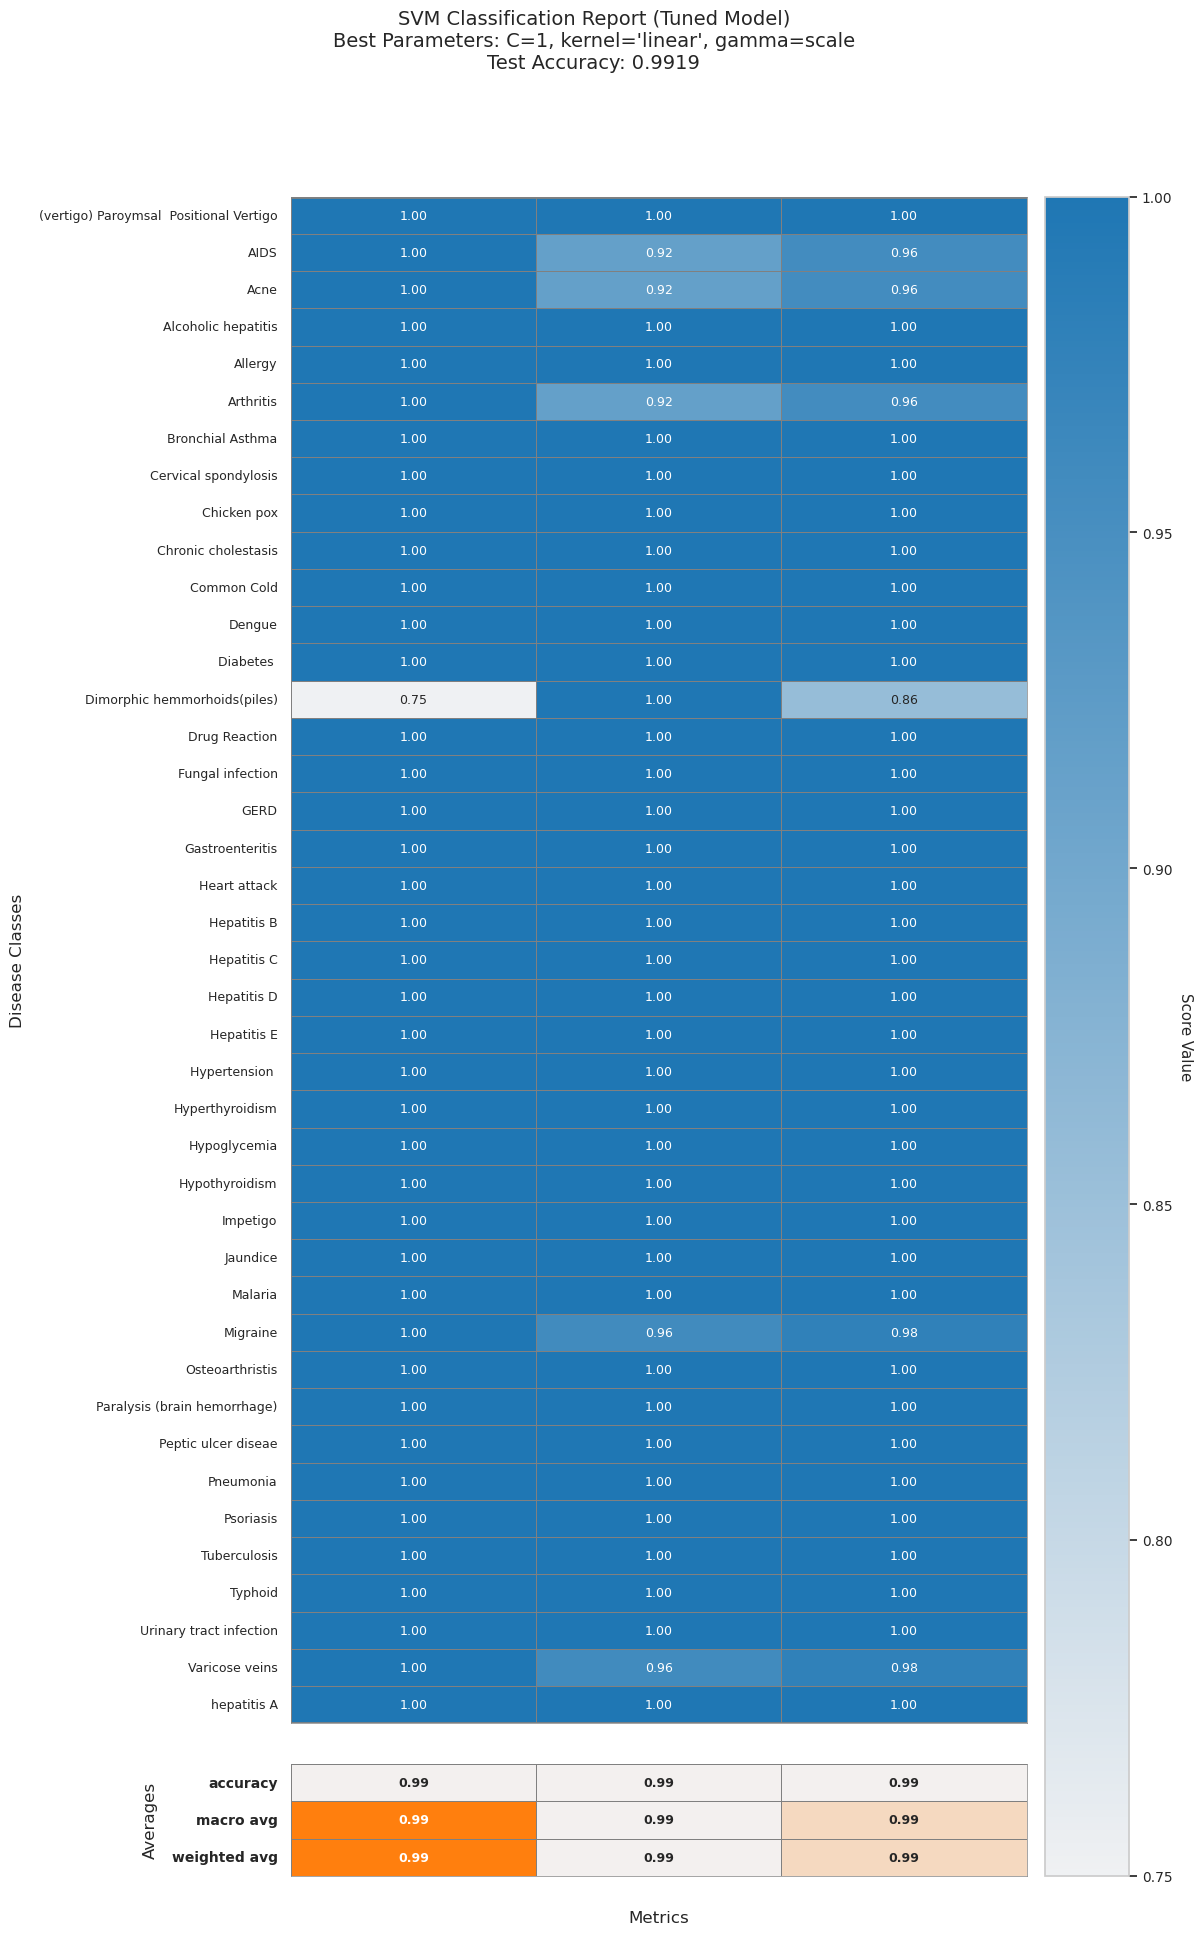

In [109]:
# Generate report as DataFrame for tuned model
report_dict_tuned = classification_report(y_test, y_pred_best_svm, 
                                        target_names=label_encoder_y.classes_, 
                                        output_dict=True)
report_df_tuned = pd.DataFrame(report_dict_tuned).transpose()

# Separate the class metrics from the averages
class_metrics_tuned = report_df_tuned.iloc[:-3, :3]  # Precision, Recall, F1 for classes
avg_metrics_tuned = report_df_tuned.iloc[-3:, :3]    # Precision, Recall, F1 averages

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(
    nrows=2, 
    figsize=(12, fig_height + 2),  # Same sizing as before
    gridspec_kw={'height_ratios': [num_classes, 3]},
    sharex=True
)

# Main colormap for classes (same as before)
cmap_main = sns.light_palette("#1f77b4", as_cmap=True)
cmap_avg = sns.light_palette("#ff7f0e", as_cmap=True)

# Draw heatmap for classes (tuned model)
sns.heatmap(
    class_metrics_tuned,
    annot=True,
    cmap=cmap_main,
    fmt='.2f',
    linewidths=0.4,
    linecolor='gray',
    cbar=False,
    square=False,
    ax=ax1,
    annot_kws={'fontsize': 9}
)

# Draw heatmap for averages (tuned model)
sns.heatmap(
    avg_metrics_tuned,
    annot=True,
    cmap=cmap_avg,
    fmt='.2f',
    linewidths=0.4,
    linecolor='gray',
    cbar=False,
    square=False,
    ax=ax2,
    annot_kws={'fontsize': 9, 'fontweight': 'bold'}
)

# Titles & labels with tuning info
title_text = (f"SVM Classification Report (Tuned Model)\n"
             f"Best Parameters: C={grid_search.best_params_['C']}, "
             f"kernel='{grid_search.best_params_['kernel']}', "
             f"gamma={grid_search.best_params_['gamma']}\n"
             f"Test Accuracy: {accuracy_best_svm:.4f}")

fig.suptitle(title_text, fontsize=14, y=1.05)
ax1.set_ylabel('Disease Classes', fontsize=12, labelpad=10)
ax2.set_ylabel('Averages', fontsize=12, labelpad=10)
ax2.set_xlabel('Metrics', fontsize=12, labelpad=15)

# Ticks styling
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, fontsize=10)
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=9)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, fontsize=10)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, fontsize=10, fontweight='bold')

# Add borders
for ax in [ax1, ax2]:
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5)

# Add a divider between the two heatmaps
ax1.axhline(y=0, color='gray', linewidth=2)
ax1.axhline(y=len(class_metrics_tuned), color='gray', linewidth=2)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)

# Add a colorbar for the main heatmap
cbar = fig.colorbar(ax1.collections[0], ax=[ax1, ax2], location='right', pad=0.02)
cbar.ax.set_ylabel('Score Value', rotation=270, labelpad=15)

plt.show()

## 7. Evaluate Tuned SVM Model

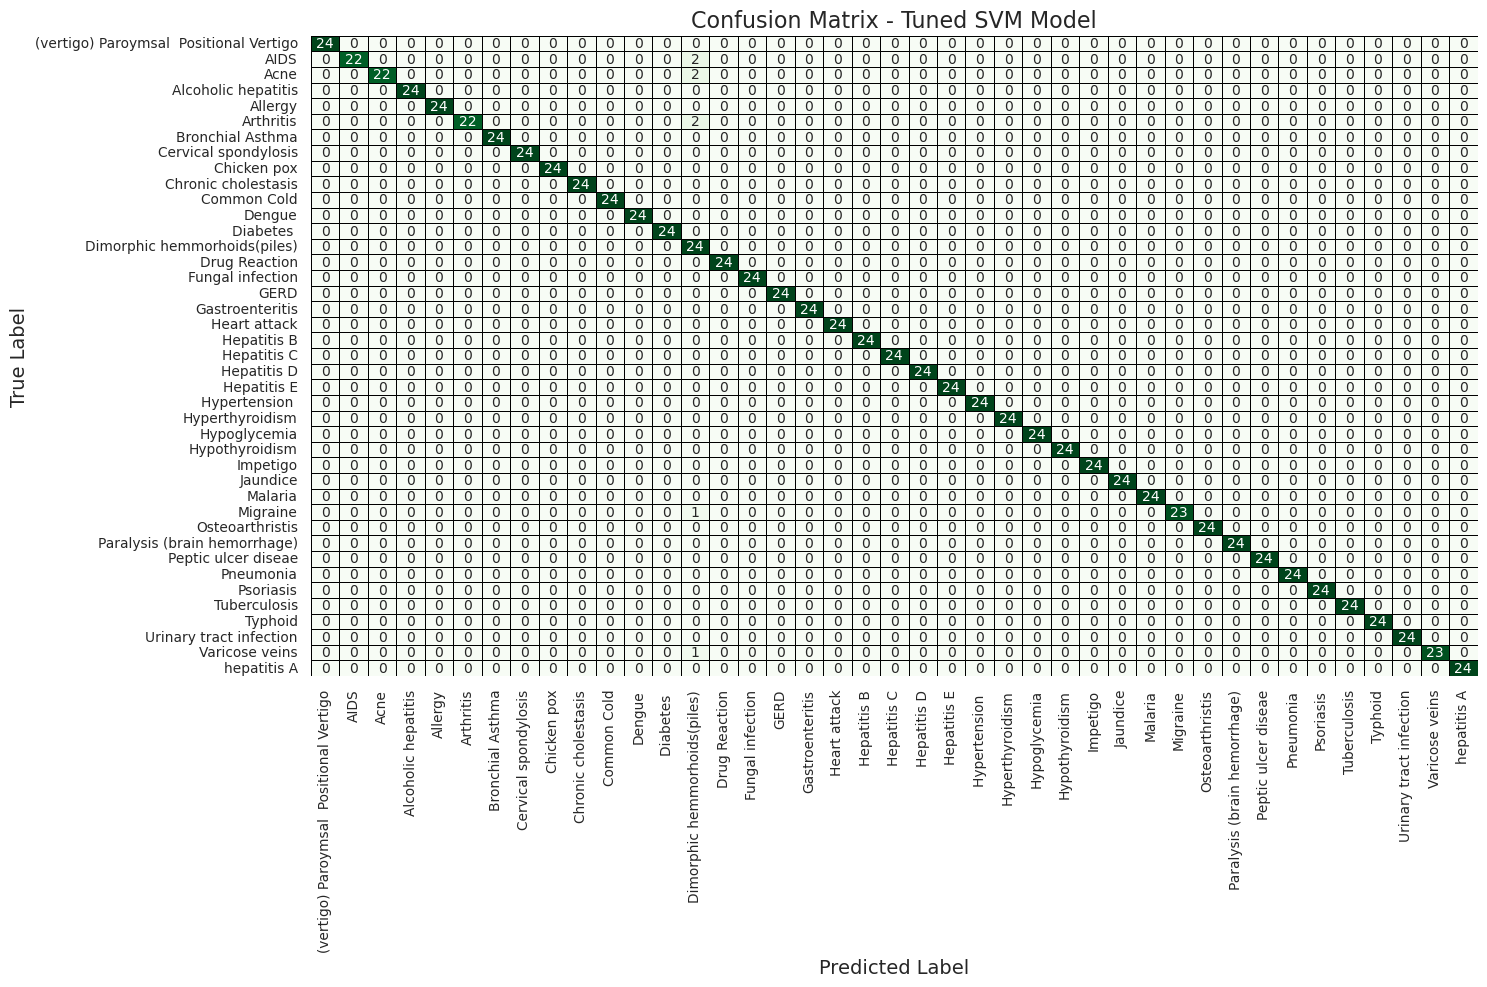

In [110]:
# --- Confusion Matrix (Tuned Model) --- 
conf_matrix_best = confusion_matrix(y_test, y_pred_best_svm)

plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=label_encoder_y.classes_, yticklabels=label_encoder_y.classes_,
            annot_kws={"size": 10}, linewidths=0.5, linecolor='black')
plt.title("Confusion Matrix - Tuned SVM Model", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

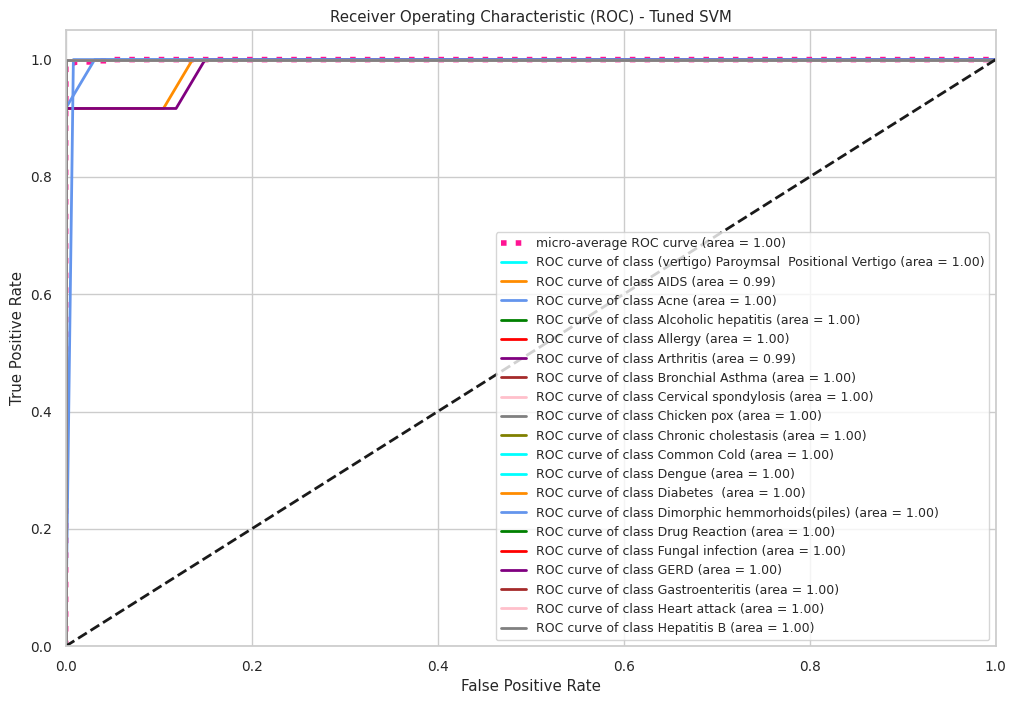

In [111]:
# --- ROC/AUC Curve Plotting (Tuned Model) --- 

# Compute ROC curve and ROC area for each class
fpr_best = dict()
tpr_best = dict()
roc_auc_best = dict()
for i in range(n_classes):
    fpr_best[i], tpr_best[i], _ = roc_curve(y_test_binarized[:, i], y_proba_best_svm[:, i])
    roc_auc_best[i] = auc(fpr_best[i], tpr_best[i])

# Compute micro-average ROC curve and ROC area
fpr_best["micro"], tpr_best["micro"], _ = roc_curve(y_test_binarized.ravel(), y_proba_best_svm.ravel())
roc_auc_best["micro"] = auc(fpr_best["micro"], tpr_best["micro"])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
plt.plot(fpr_best["micro"], tpr_best["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_best["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
for i, color in zip(range(num_classes_to_plot), colors):
    plt.plot(fpr_best[i], tpr_best[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_encoder_y.classes_[i], roc_auc_best[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Tuned SVM')
plt.legend(loc="lower right", fontsize='small')
plt.show()

## 8. Feature Importance Analysis (Post-Tuning)

### 8.1 Permutation Importance

In [112]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming best_svm_model is already trained and X_test is the correctly encoded test set
# Perform permutation importance on the tuned model using the test set with multi-hot encoded features
perm_importance = permutation_importance(best_svm_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# If feature selection was performed, make sure selected features match the model's selected ones
# For example, if using SelectFromModel, selected features might have been reduced. Here, we assume all features.
# Make sure selected_feature_names match the features used for the model training

# Create a DataFrame to hold the feature names and importance scores
importance_perm_df = pd.DataFrame({
    'Feature': selected_features,  # Use the feature names after multi-hot encoding
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
})

# Sort by importance
importance_perm_df = importance_perm_df.sort_values(by='Importance', ascending=False)


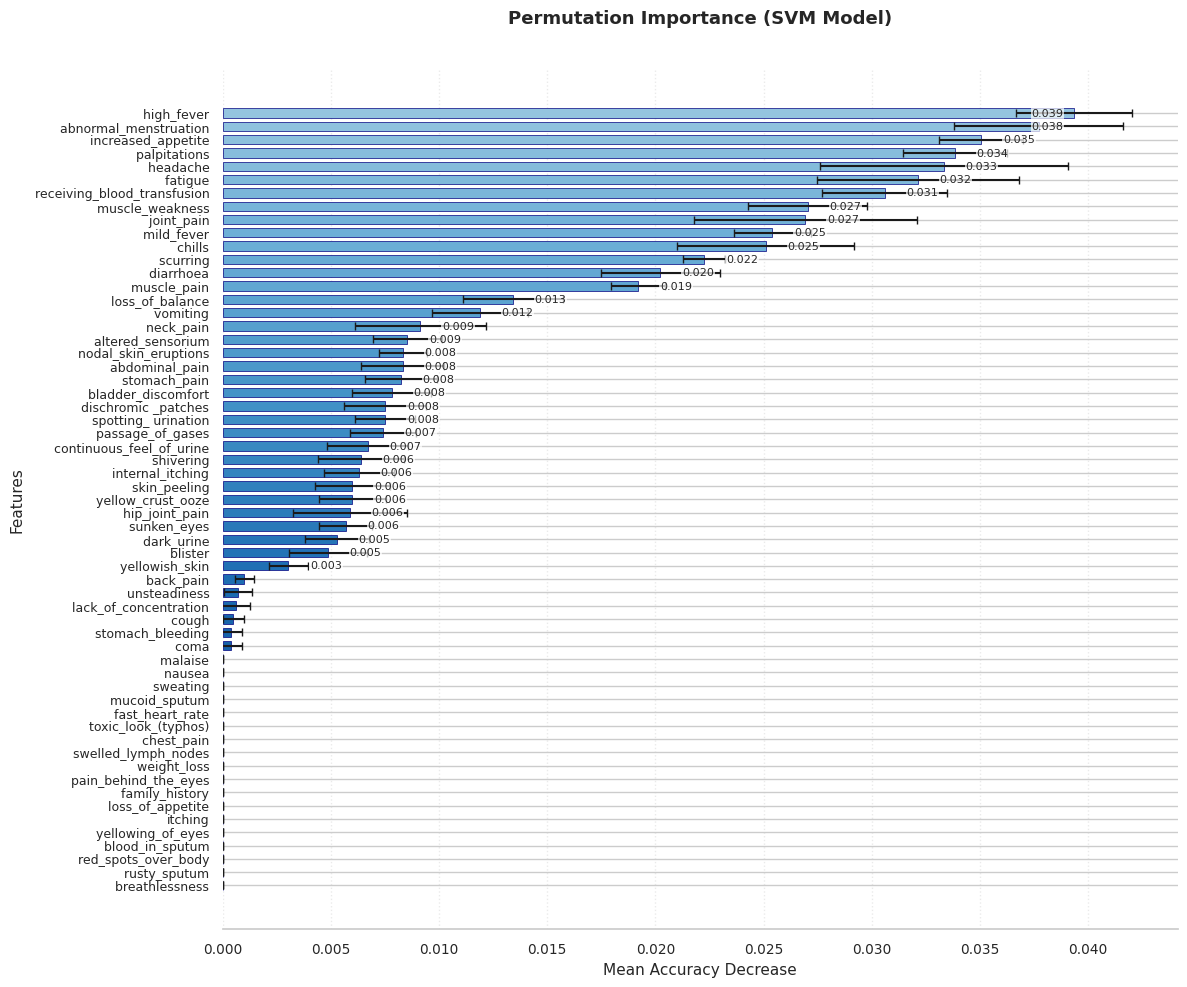

In [113]:
plt.figure(figsize=(12, 10))  # Slightly taller figure

# Custom blue color palette with more contrast
colors = plt.cm.Blues(np.linspace(0.4, 1, len(importance_perm_df)))  # Start from darker blue

# Horizontal bar plot with adjusted spacing
bars = plt.barh(
    importance_perm_df['Feature'],
    importance_perm_df['Importance'],
    xerr=importance_perm_df['Std'],
    capsize=3,  # Smaller capsize
    color=colors,
    edgecolor='navy',
    linewidth=0.5,
    height=0.7  # Thinner bars for more vertical space
)

# Smart label placement
for i, bar in enumerate(bars):
    width = bar.get_width()
    # Only label bars wider than 5% of max width
    if width > (0.05 * importance_perm_df['Importance'].max()):
        plt.text(
            min(width + 0.001, 0.95 * max(importance_perm_df['Importance'])),  # Don't overflow
            bar.get_y() + bar.get_height()/2,
            f'{width:.3f}',
            va='center',
            ha='left',
            fontsize=8,  # Smaller font
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.5)  # White background
        )

# Improved styling
plt.title('Permutation Importance (SVM Model)\n', fontsize=13, pad=18, fontweight='bold')
plt.xlabel('Mean Accuracy Decrease', fontsize=11)
plt.ylabel('Features', fontsize=11)
plt.yticks(fontsize=9)  # Smaller feature names
plt.gca().invert_yaxis()

# Better grid and layout
plt.grid(axis='x', linestyle=':', alpha=0.4)
plt.xlim(left=0)  # Start at zero
sns.despine(left=True)

# Adjust margins
plt.subplots_adjust(left=0.3, right=0.95, top=0.9, bottom=0.1)
plt.tight_layout()

plt.savefig('permutation_importance_clean.png', dpi=300, bbox_inches='tight')
plt.show()

In [114]:
# Create and style table
styled_table = (
    importance_perm_df
    .style
    .background_gradient(cmap='Blues', subset=['Importance'])
    .bar(subset=['Std'], color='#5f9ea0')  # Cadet blue for std dev
    .format({'Importance': '{:.3f}', 'Std': '{:.3f}'})
    .set_caption('Permutation Importance Results')
    .set_properties(**{
        'border': '1px solid white',
        'text-align': 'center',
        'font-size': '11pt'
    })
)

# Display in notebook
display(styled_table)

# Export as image (requires dataframe_image)
try:
    import dataframe_image as dfi
    dfi.export(styled_table, 'permutation_importance_table.png', dpi=300)
except:
    print("Tip: Install dataframe_image with `pip install dataframe_image` for table exports")

,Feature,Importance,Std
41,high_fever,0.039,0.003
4,abnormal_menstruation,0.038,0.004
47,increased_appetite,0.035,0.002
45,palpitations,0.034,0.002
35,headache,0.033,0.006
0,fatigue,0.032,0.005
34,receiving_blood_transfusion,0.031,0.003
3,muscle_weakness,0.027,0.003
22,joint_pain,0.027,0.005
12,mild_fever,0.025,0.002


Tip: Install dataframe_image with `pip install dataframe_image` for table exports


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# === Assume the following variables are already defined ===
# best_svm_model:  tuned SVM model
# X_train_selected, X_test: training and test sets after initial RF-based feature selection
# selected_features: the list of feature names that were used for training (e.g., 61 features from RF selection)
# y_train, y_test:  training and test labels

# --- Convert X_train_selected and X_test to DataFrames if needed ---
if not isinstance(X_train_selected, pd.DataFrame):
    X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)
if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test, columns=selected_features)

# And then you choose the top N features:
top_n = 59  
top_n_features = importance_perm_df.head(top_n)['Feature'].values

# --- Filter the training and test sets to contain only these top N features ---
X_train_reduced = X_train_selected.loc[:, top_n_features]
X_test_reduced = X_test.loc[:, top_n_features]

# Option 1: Retrain on the reduced training set and evaluate on test set (single split)
best_svm_model.fit(X_train_reduced, y_train)
y_pred = best_svm_model.predict(X_test_reduced)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy with Top {top_n} Features: {test_accuracy:.4f}")
print("\nClassification Report (Single Split):")
print(classification_report(y_test, y_pred))

# Option 2: Combine reduced data for cross-validation
# (This assumes you want to assess model performance over the entire dataset)
X_reduced_full = np.concatenate([X_train_reduced, X_test_reduced])
y_full = np.concatenate([y_train, y_test])

# Perform 5-fold cross-validation
cv_scores = cross_val_score(best_svm_model, X_reduced_full, y_full, cv=5)
print("\nCross Validation Scores:", cv_scores)
print("Mean CV Score: {:.4f}, Std: {:.4f}".format(cv_scores.mean(), cv_scores.std()))

# Get cross-validated predictions for a full classification report
y_pred_cv = cross_val_predict(best_svm_model, X_reduced_full, y_full, cv=5)
print("\nClassification Report (Cross-Validated):")
print(classification_report(y_full, y_pred_cv))


Test Accuracy with Top 59 Features: 0.9919

Classification Report (Single Split):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      0.92      0.96        24
           2       1.00      0.92      0.96        24
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        24
           5       1.00      0.92      0.96        24
           6       1.00      1.00      1.00        24
           7       1.00      1.00      1.00        24
           8       1.00      1.00      1.00        24
           9       1.00      1.00      1.00        24
          10       1.00      1.00      1.00        24
          11       1.00      1.00      1.00        24
          12       1.00      1.00      1.00        24
          13       0.75      1.00      0.86        24
          14       1.00      1.00      1.00        24
          15       1.00      1.00      1.00        24

In [ ]:
# # Option 1: Retrain on the reduced training set and evaluate on test set (single split)
# best_svm_model.fit(X_train_reduced, y_train)
# y_pred = best_svm_model.predict(X_test_reduced)
# test_accuracy = accuracy_score(y_test, y_pred)
# print(f"Test Accuracy with Top {top_n} Features: {test_accuracy:.4f}")
# print("\nClassification Report (Single Split):")
# print(classification_report(y_test, y_pred))

# # Option 2: Combine your reduced data for cross-validation
# # (This assumes you want to assess model performance over the entire dataset)
# X_reduced_full = np.concatenate([X_train_reduced, X_test_reduced])
# y_full = np.concatenate([y_train, y_test])

# # Perform 5-fold cross-validation
# cv_scores = cross_val_score(best_svm_model, X_reduced_full, y_full, cv=5)
# print("\nCross Validation Scores:", cv_scores)
# print("Mean CV Score: {:.4f}, Std: {:.4f}".format(cv_scores.mean(), cv_scores.std()))

# # Get cross-validated predictions for a full classification report
# y_pred_cv = cross_val_predict(best_svm_model, X_reduced_full, y_full, cv=5)
# print("\nClassification Report (Cross-Validated):")
# print(classification_report(y_full, y_pred_cv))

# # Plot confusion matrix for cross-validated predictions
# cm = confusion_matrix(y_full, y_pred_cv)
# plt.figure(figsize=(12, 10))
# sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
#             xticklabels=np.unique(y_full), yticklabels=np.unique(y_full))
# plt.title("Confusion Matrix - Cross Validated")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.tight_layout()
# plt.show()

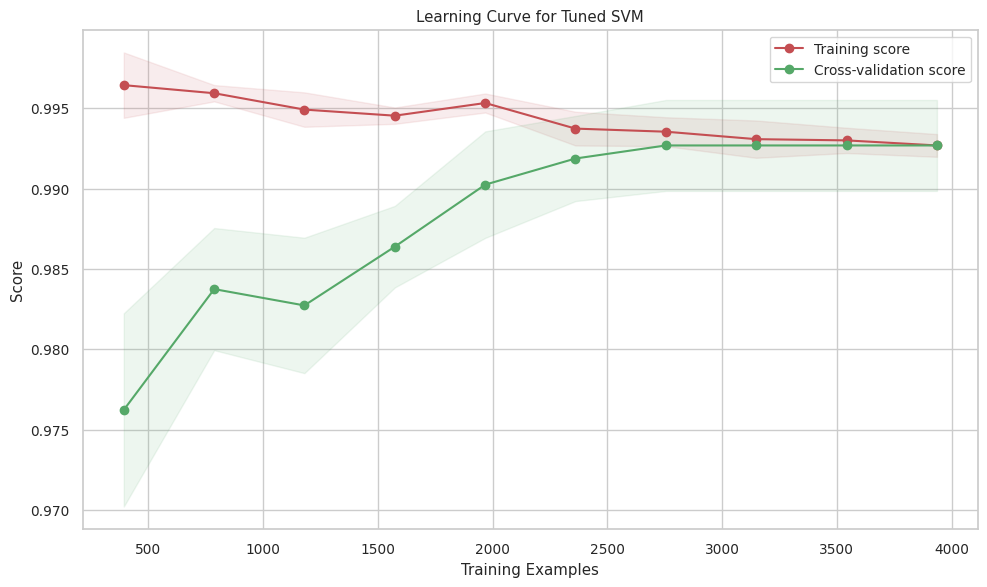

In [ ]:
# 1. Learning Curve

X_reduced_full = np.concatenate([X_train_reduced, X_test_reduced])
y_full = np.concatenate([y_train, y_test])

# Compute learning curve (using 5-fold CV)
train_sizes, train_scores, test_scores = learning_curve(
    best_svm_model, X_reduced_full, y_full, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Compute mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std(train_scores, axis=1)
test_scores_mean  = np.mean(test_scores, axis=1)
test_scores_std   = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curve for Tuned SVM")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

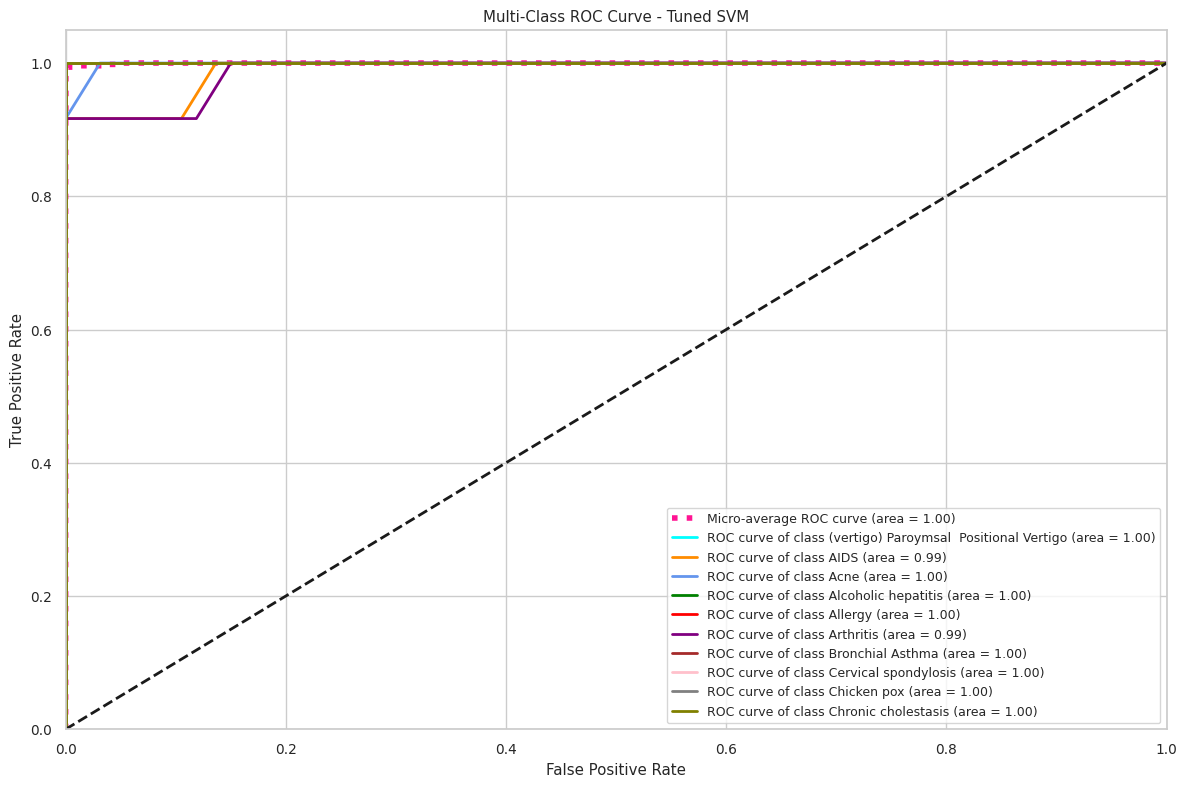

In [ ]:
# 2. ROC Curve (Multi-Class)

# Compute predicted probabilities on the test set with reduced features.
y_proba = best_svm_model.predict_proba(X_test_reduced)

# Determine number of classes
n_classes = len(np.unique(y_test))

# Binarize the test labels for ROC analysis
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot ROC curve for a subset of classes for clarity (e.g., first 10 classes)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red',
                'purple', 'brown', 'pink', 'gray', 'olive'])
num_classes_to_plot = min(n_classes, 10)
for i, color in zip(range(num_classes_to_plot), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(label_encoder_y.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve - Tuned SVM')
plt.legend(loc="lower right", fontsize='small')
plt.tight_layout()
plt.show()


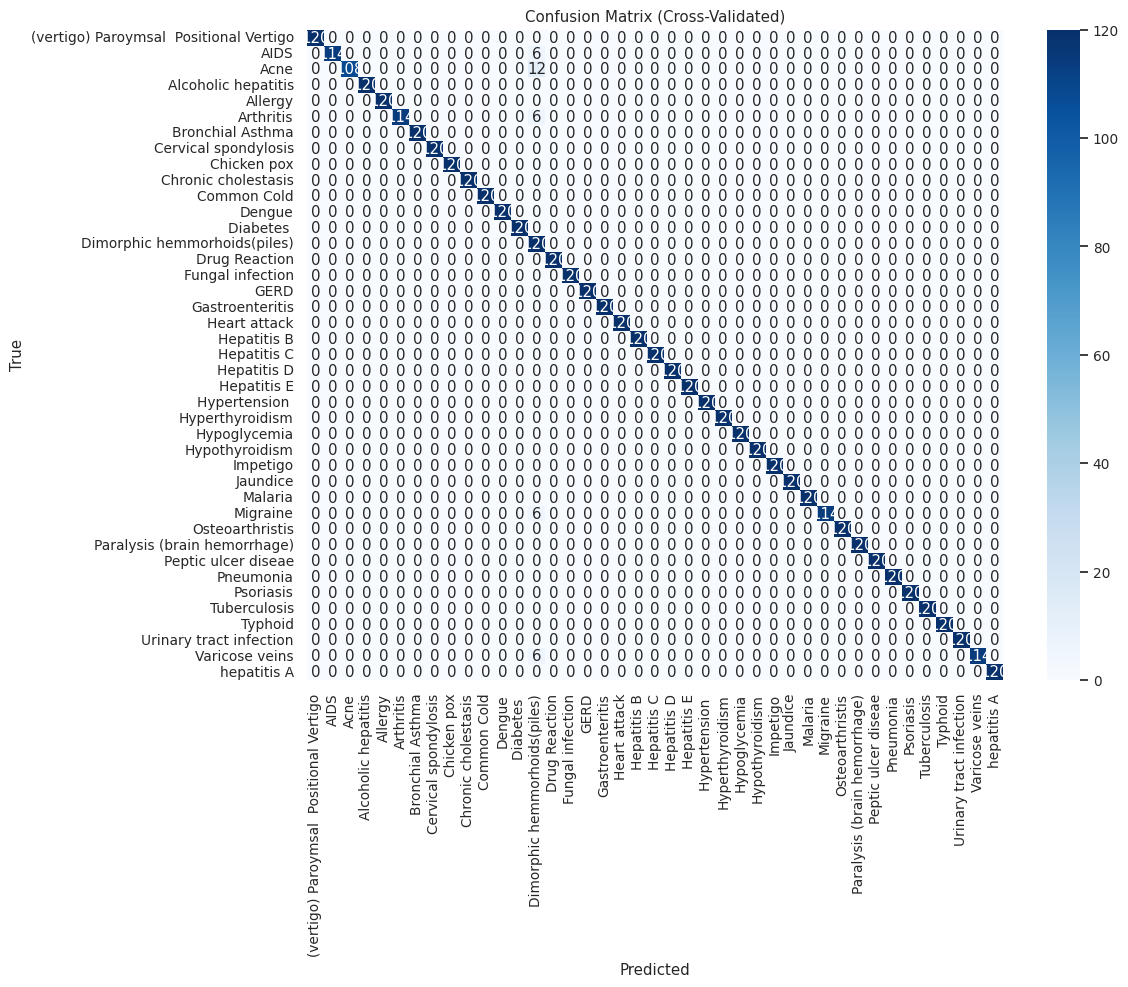

In [ ]:
# 3. Confusion Matrix (Cross-Validated Predictions)


from sklearn.model_selection import cross_val_predict

# Get cross-validated predictions on the full reduced dataset
y_pred_cv = cross_val_predict(best_svm_model, X_reduced_full, y_full, cv=5)

# Compute and plot confusion matrix
cm = confusion_matrix(y_full, y_pred_cv)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=label_encoder_y.classes_,
            yticklabels=label_encoder_y.classes_)
plt.title("Confusion Matrix (Cross-Validated)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [ ]:
# 4. Final Evaluation Report


# Evaluate using a classification report on the cross-validated predictions
from sklearn.metrics import classification_report
print("Classification Report (Cross-Validated):")
print(classification_report(y_full, y_pred_cv))


Classification Report (Cross-Validated):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       120
           1       1.00      0.95      0.97       120
           2       1.00      0.90      0.95       120
           3       1.00      1.00      1.00       120
           4       1.00      1.00      1.00       120
           5       1.00      0.95      0.97       120
           6       1.00      1.00      1.00       120
           7       1.00      1.00      1.00       120
           8       1.00      1.00      1.00       120
           9       1.00      1.00      1.00       120
          10       1.00      1.00      1.00       120
          11       1.00      1.00      1.00       120
          12       1.00      1.00      1.00       120
          13       0.77      1.00      0.87       120
          14       1.00      1.00      1.00       120
          15       1.00      1.00      1.00       120
          16       1.00      1.00      1

### Interpretation of Permutation Importance
Permutation importance measures the decrease in model score (accuracy in this case) when a single feature's values are randomly shuffled. A larger decrease indicates a more important feature. This method assesses feature importance directly on the trained model's performance on the test set.

### 8.2 SHAP (SHapley Additive exPlanations)

In [ ]:
import shap
import pandas as pd

# --- SHAP Analysis (Corrected) ---
# Ensure that best_svm_model is trained with probability=True to use predict_proba method.
# Create the background dataset (a small subset of the training data, for faster computation).
background_data = shap.sample(X_train_selected, 100)

# Create a SHAP explainer object using the SVM model's predict_proba method.
# This method must be available if probability=True was used during training.
explainer = shap.KernelExplainer(best_svm_model.predict_proba, background_data)

# Use a smaller sample of the test data for faster SHAP value calculation and plotting
test_sample = shap.sample(X_test, 200) 

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(test_sample)

# Convert selected feature names to a list for plotting
selected_feature_names_list = selected_features.tolist()



100%|██████████| 200/200 [32:03<00:00,  9.62s/it] 


### Interpretation of SHAP Plots
**Summary Plot:** This plot shows the impact of each feature on the model's output for a specific class. Each point represents a Shapley value for a feature and an instance. The position on the y-axis indicates the feature, and the position on the x-axis shows the SHAP value (impact on prediction). Color indicates the feature value (red=high, blue=low).

**Force Plot:** This plot explains a single prediction. Features pushing the prediction higher (towards the predicted class) are shown in red, and those pushing it lower are in blue. The length of the bar indicates the magnitude of the feature's impact. The `base value` is the average prediction over the background dataset.

## 9. Conclusion and Next Steps
This notebook demonstrated training an SVM model for disease prediction, including preprocessing, feature selection, hyperparameter tuning, and detailed evaluation using confusion matrices, ROC/AUC curves, and feature importance analysis (Permutation Importance, SHAP).

**Insights:**
*   The tuned SVM model achieved high accuracy after hyperparameter optimization.
*   ROC/AUC curves provide a nuanced view of performance across classes.
*   Feature importance methods (Random Forest, Permutation Importance, SHAP) highlight the most influential symptoms in the model's predictions.

**Potential Next Steps:**
*   **Explore Feature Interactions:** Use SHAP dependence plots to understand how pairs of features interact.
*   **Alternative Models:** Compare SVM performance with other classification algorithms (e.g., Logistic Regression, Gradient Boosting).
*   **Advanced Imputation:** Investigate more sophisticated methods for handling missing symptom data if the simple '0' imputation is not appropriate.
*   **Clinical Validation:** Discuss the feature importance results with domain experts to validate their clinical relevance.